# Predicting Air Temperature through Many Particles Type in The Air

Outline : 
1. Identifying the correlation through Exploratory Data Analysis on every variables that effects Air Temperature
2. Identifying pattern and season of the air temperature over the hours, days, weeks, months and years
2. Predicting the future air temperature based on LSTM deep learning architecture approach
4. Have a deeper understanding about the differences between structure model and its impact through fine tuning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew

from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [57]:
df = pd.read_csv("AP003.csv")
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67


# 1.a. Exploratory Data Analysis

## 1. Dataset General Information

In [58]:
df.shape

(50400, 23)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        50400 non-null  object 
 1   To Date          50400 non-null  object 
 2   PM2.5 (ug/m3)    44691 non-null  float64
 3   PM10 (ug/m3)     45018 non-null  float64
 4   NO (ug/m3)       46252 non-null  float64
 5   NO2 (ug/m3)      45705 non-null  float64
 6   NOx (ppb)        47040 non-null  float64
 7   NH3 (ug/m3)      45756 non-null  float64
 8   SO2 (ug/m3)      43604 non-null  float64
 9   CO (mg/m3)       46993 non-null  float64
 10  Ozone (ug/m3)    45309 non-null  float64
 11  Benzene (ug/m3)  46678 non-null  float64
 12  Toluene (ug/m3)  46678 non-null  float64
 13  Temp (degree C)  46335 non-null  float64
 14  RH (%)           46520 non-null  float64
 15  WS (m/s)         46522 non-null  float64
 16  WD (degree)      44710 non-null  float64
 17  SR (W/mt2)  

In [60]:
num_col = df.select_dtypes(include = ['float64'])
cat_col = df.select_dtypes(include = ['object'])

Because the date is categorized as an object datatype, then it is needed to be converted to a python datetime datatype

In [61]:
for col in cat_col:
    df[col] = pd.to_datetime(df[col])
    display(df[col].dtype)

dtype('<M8[ns]')

dtype('<M8[ns]')

In [62]:
df.describe()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
count,50400,50400,44691.000000,45018.000000,46252.000000,45705.000000,47040.000000,45756.000000,43604.000000,46993.000000,...,46335.000000,46520.000000,46522.000000,44710.000000,47045.000000,43680.000000,47043.000000,46370.000000,47148.000000,46658.000000
mean,2020-05-15 23:30:00,2020-05-16 00:30:00,46.869591,111.938589,14.817678,34.921808,29.857413,13.813287,12.323789,0.666865,...,29.408316,73.166650,1.895205,209.078558,127.619004,746.903387,0.017120,27.591552,0.022934,2.649006
min,2017-07-01 00:00:00,2017-07-01 01:00:00,0.250000,1.000000,0.030000,0.030000,0.000000,0.020000,0.030000,0.000000,...,6.700000,15.750000,0.100000,7.000000,0.000000,700.000000,-0.550000,5.180000,0.000000,0.000000
25%,2018-12-07 23:45:00,2018-12-08 00:45:00,23.415000,63.330000,2.915000,18.400000,12.670000,7.050000,6.350000,0.330000,...,27.900000,68.000000,0.880000,157.250000,6.250000,743.000000,0.000000,24.830000,0.000000,0.570000
50%,2020-05-15 23:30:00,2020-05-16 00:30:00,38.750000,97.750000,6.600000,30.300000,22.910000,11.600000,10.680000,0.590000,...,28.850000,74.330000,1.800000,220.000000,8.250000,747.500000,0.000000,27.650000,0.000000,1.300000
75%,2021-10-22 23:15:00,2021-10-23 00:15:00,62.330000,137.500000,17.300000,43.900000,36.930000,16.770000,15.520000,0.890000,...,30.180000,79.670000,2.730000,262.670000,227.500000,751.000000,0.050000,30.400000,0.000000,2.770000
max,2023-03-31 23:00:00,2023-04-01 00:00:00,840.000000,904.000000,419.780000,420.200000,408.250000,454.900000,194.250000,11.280000,...,59.880000,92.000000,7.970000,360.000000,730.000000,770.000000,1.680000,48.500000,12.500000,410.850000
std,NaN,NaN,35.201161,74.285923,22.372042,23.912796,27.042412,14.685377,10.266289,0.550187,...,3.228845,8.592562,1.199727,67.168061,175.790733,7.656193,0.071902,4.426638,0.282441,8.785483


This brief statistical description explains that the dataset contains a record of Air Quality from **1st July 2017** until **31st March 2023**

## 2. Missing Values Information

In [63]:
null_col = []
for col in num_col:
    if df[col].isna().sum() > 0:
        null_col.append(col)
        print(f"=== {col} Column ===")
        print("Null Counts", df[col].isna().sum())
        print("Null Percentage", round(df[col].isna().sum()/df.shape[0]*100, 2), "%")
        print()
        print()

=== PM2.5 (ug/m3) Column ===
Null Counts 5709
Null Percentage 11.33 %


=== PM10 (ug/m3) Column ===
Null Counts 5382
Null Percentage 10.68 %


=== NO (ug/m3) Column ===
Null Counts 4148
Null Percentage 8.23 %


=== NO2 (ug/m3) Column ===
Null Counts 4695
Null Percentage 9.32 %


=== NOx (ppb) Column ===
Null Counts 3360
Null Percentage 6.67 %


=== NH3 (ug/m3) Column ===
Null Counts 4644
Null Percentage 9.21 %


=== SO2 (ug/m3) Column ===
Null Counts 6796
Null Percentage 13.48 %


=== CO (mg/m3) Column ===
Null Counts 3407
Null Percentage 6.76 %


=== Ozone (ug/m3) Column ===
Null Counts 5091
Null Percentage 10.1 %


=== Benzene (ug/m3) Column ===
Null Counts 3722
Null Percentage 7.38 %


=== Toluene (ug/m3) Column ===
Null Counts 3722
Null Percentage 7.38 %


=== Temp (degree C) Column ===
Null Counts 4065
Null Percentage 8.07 %


=== RH (%) Column ===
Null Counts 3880
Null Percentage 7.7 %


=== WS (m/s) Column ===
Null Counts 3878
Null Percentage 7.69 %


=== WD (degree) Column ===


All of those columns that contain missing values has a percentage below 20% (as a threshold, on data mining and visualization theory), so it will be treated by the imputation, because it still has an enough proportion to represent the entire data distribution.

In [64]:
for col in cat_col:
    if df[col].isna().sum() > 0:
        print(f"=== {col} Column ===")
        print("Null Counts", df[col].isna().sum())
        print("Null Percentage", df[col].isna().sum()/df.shape[0])
        print()
        print()
    else:
        print("There is no missing value on",col,"column")

There is no missing value on From Date column
There is no missing value on To Date column


## 3. Numerical Variable Distribution

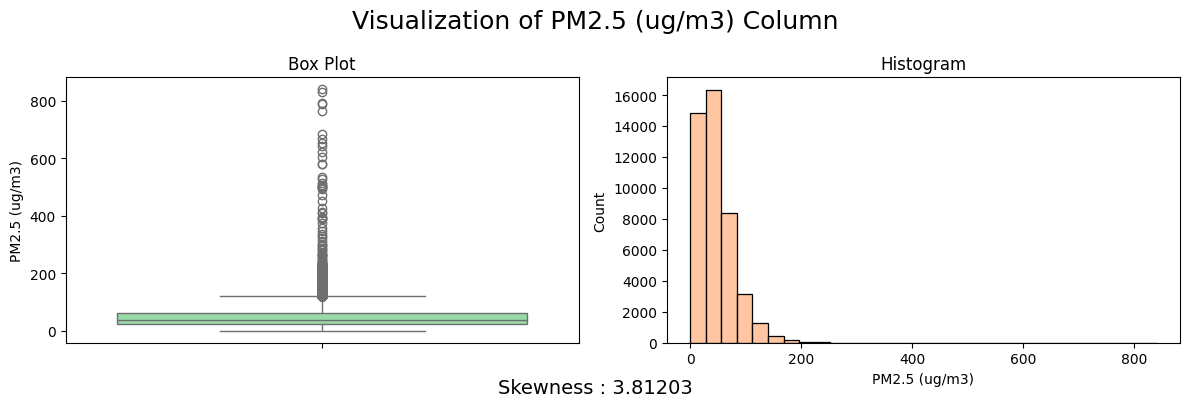

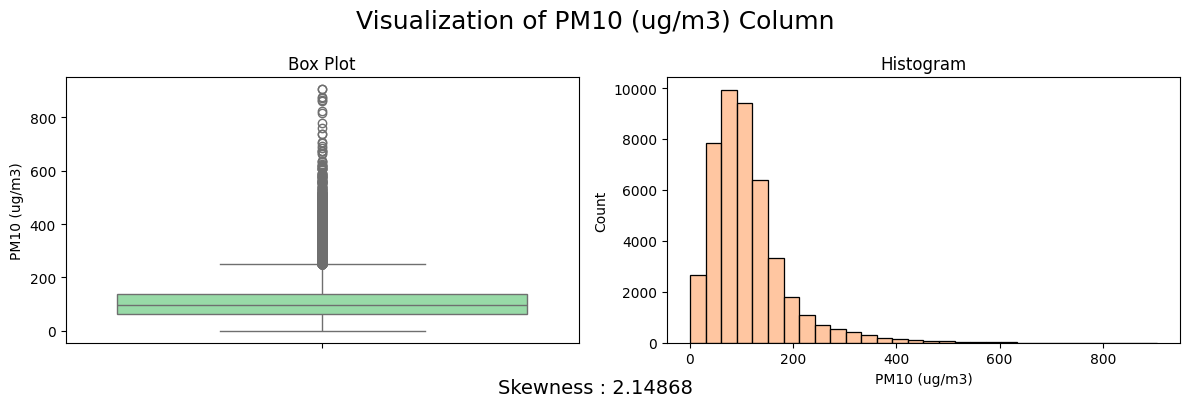

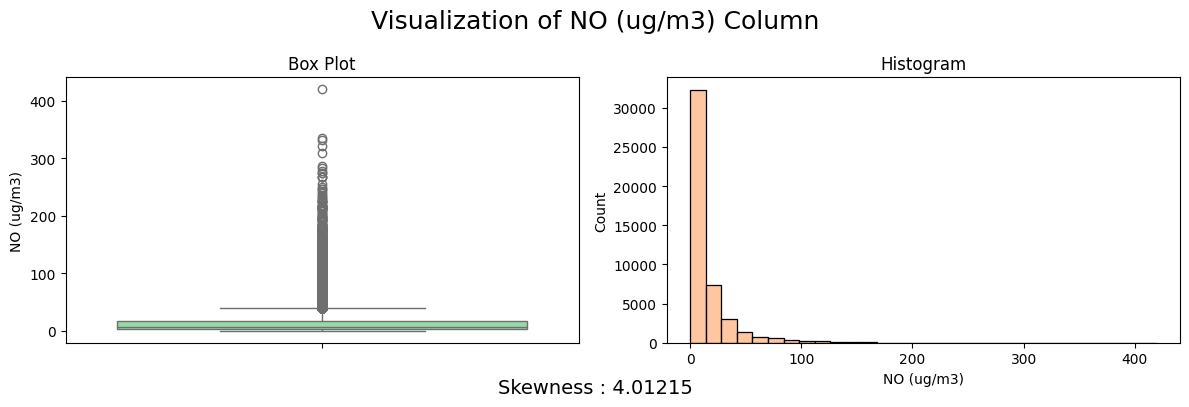

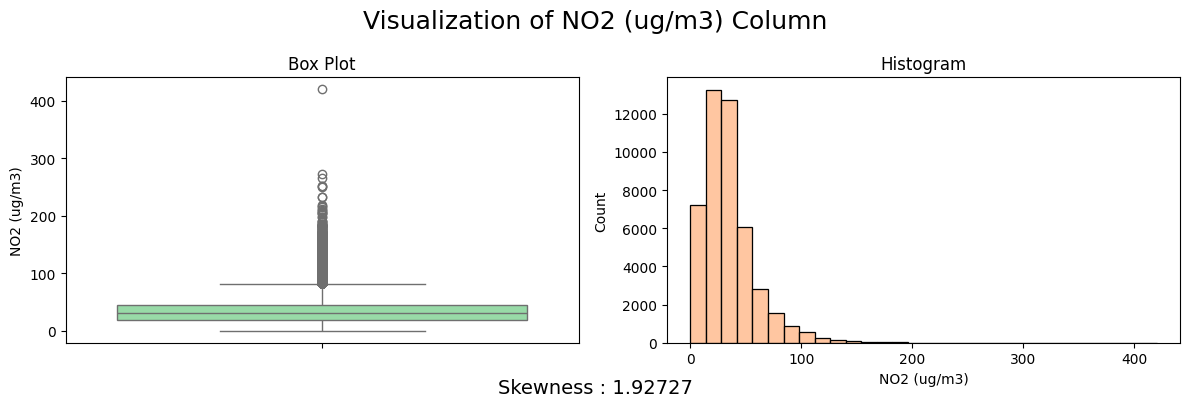

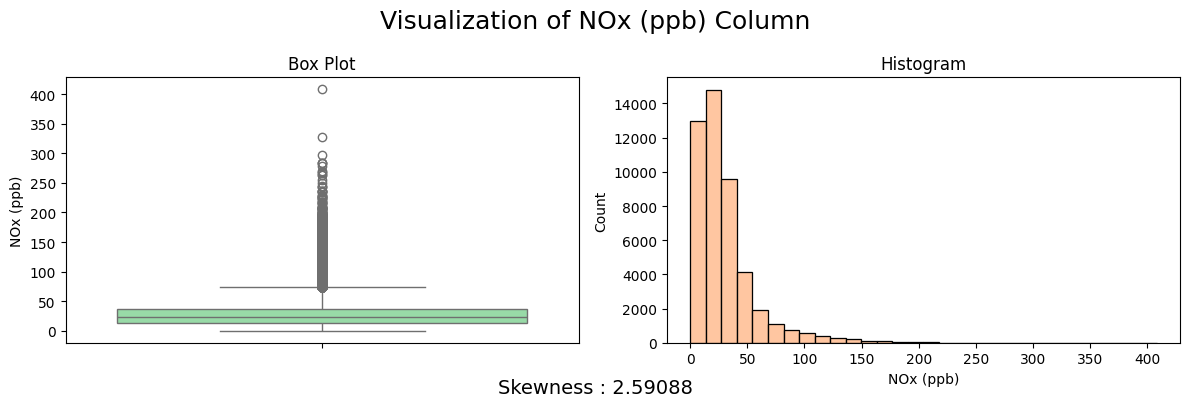

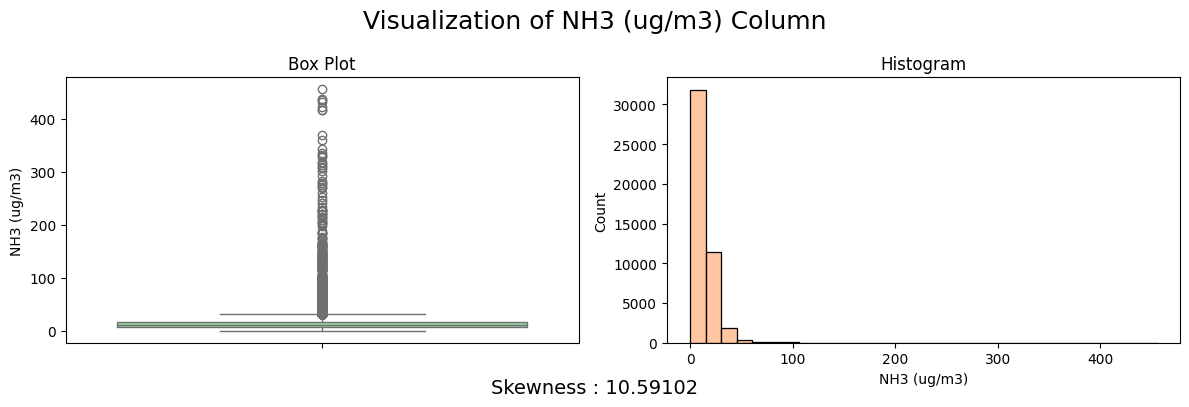

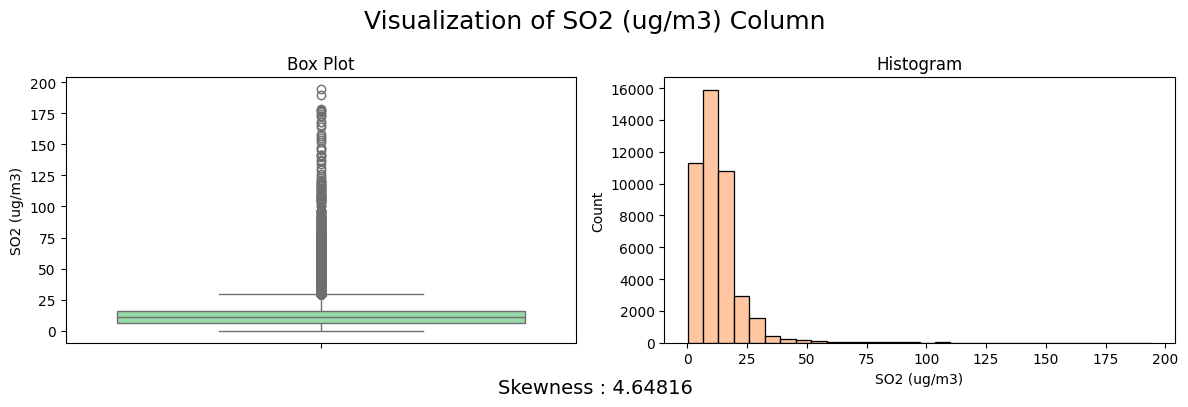

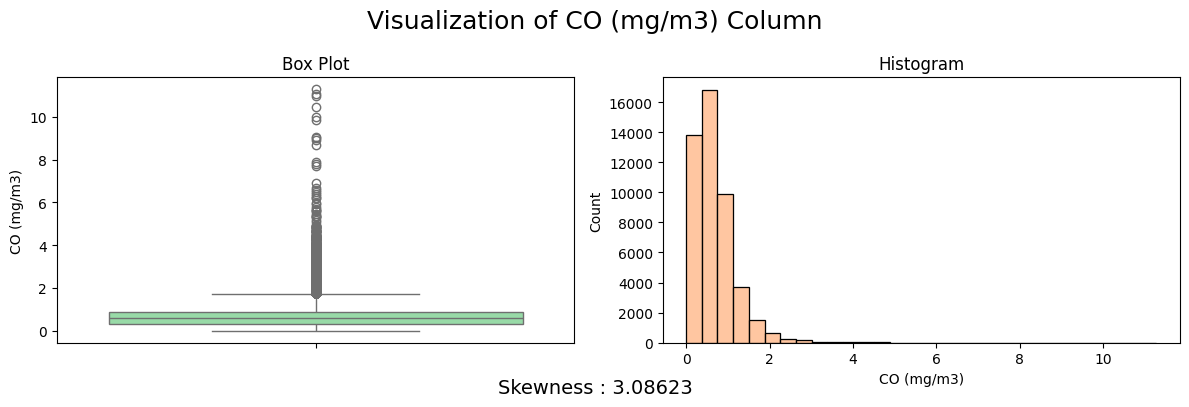

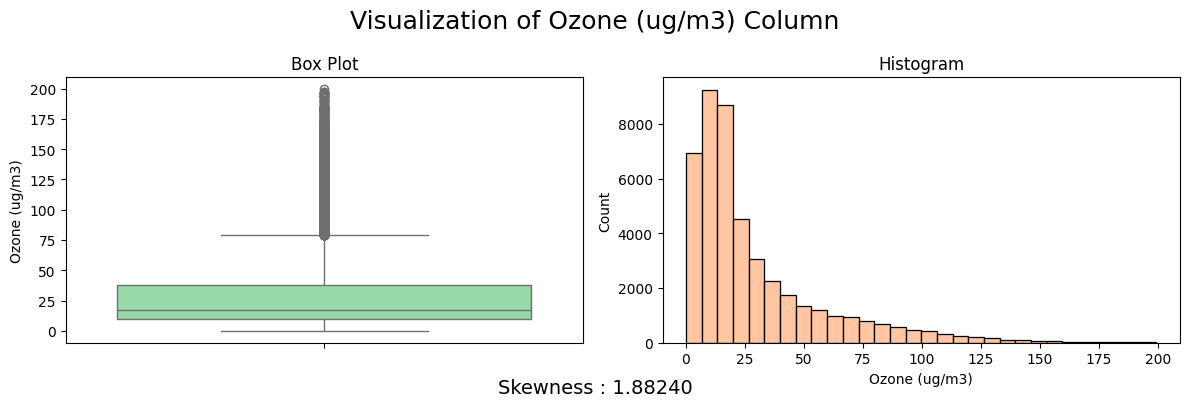

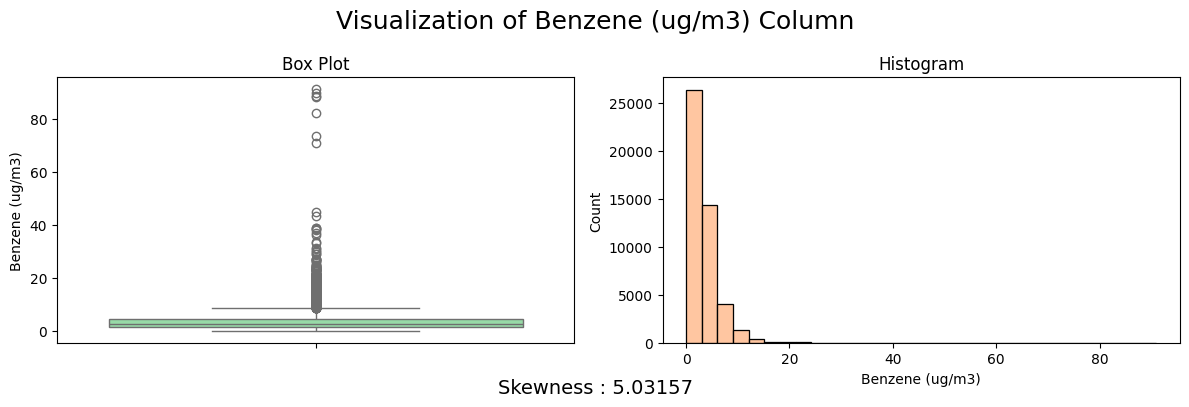

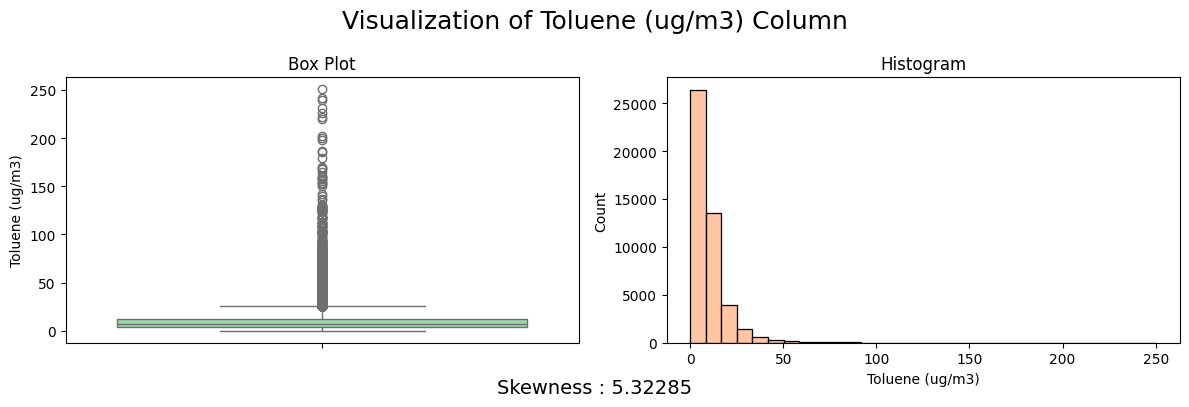

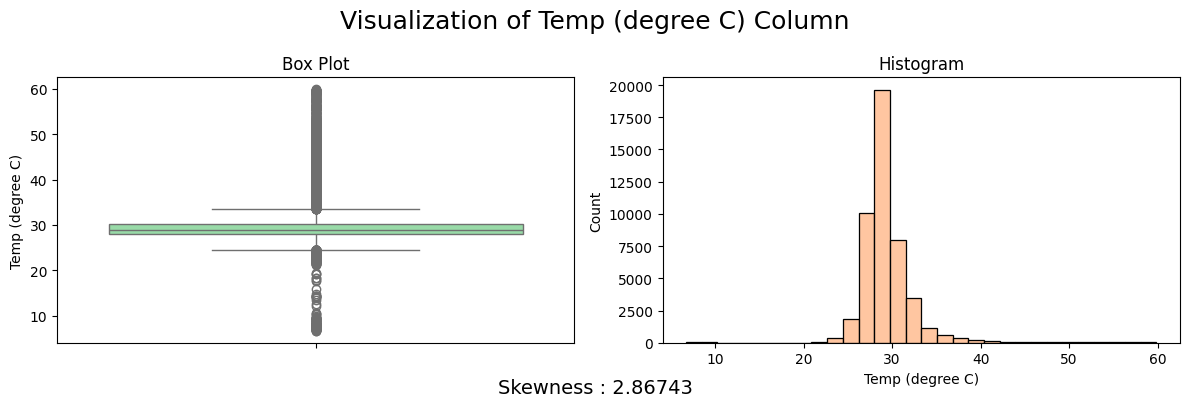

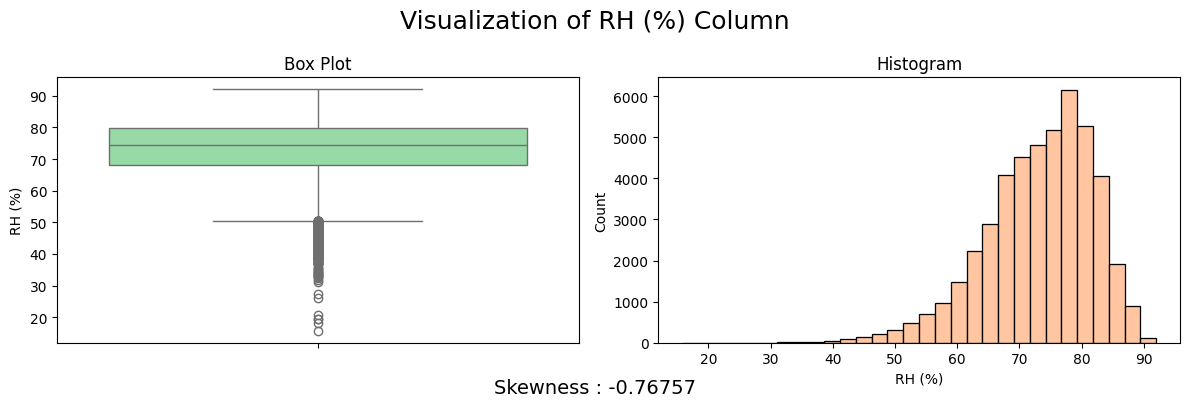

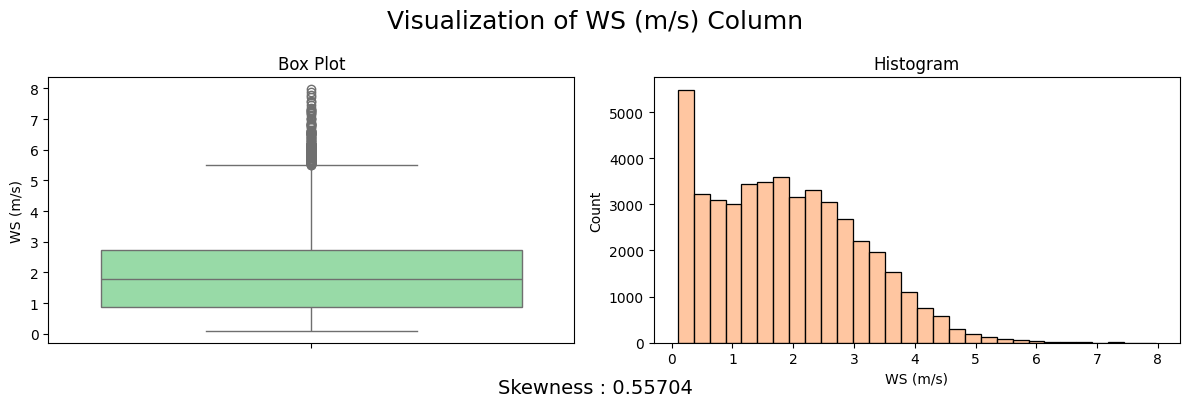

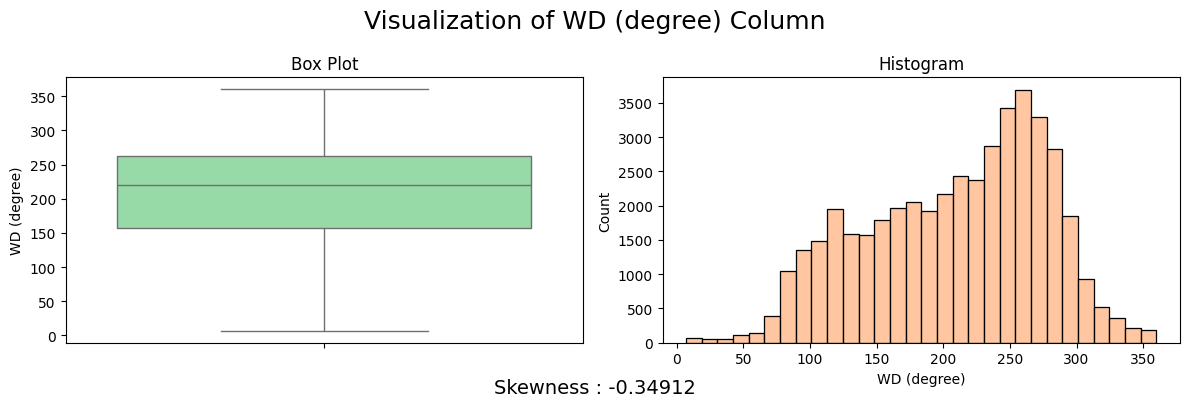

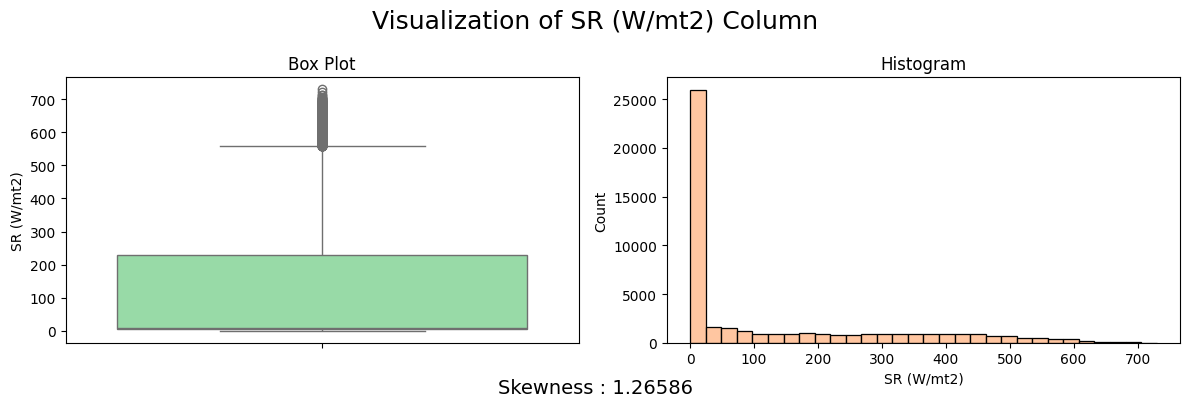

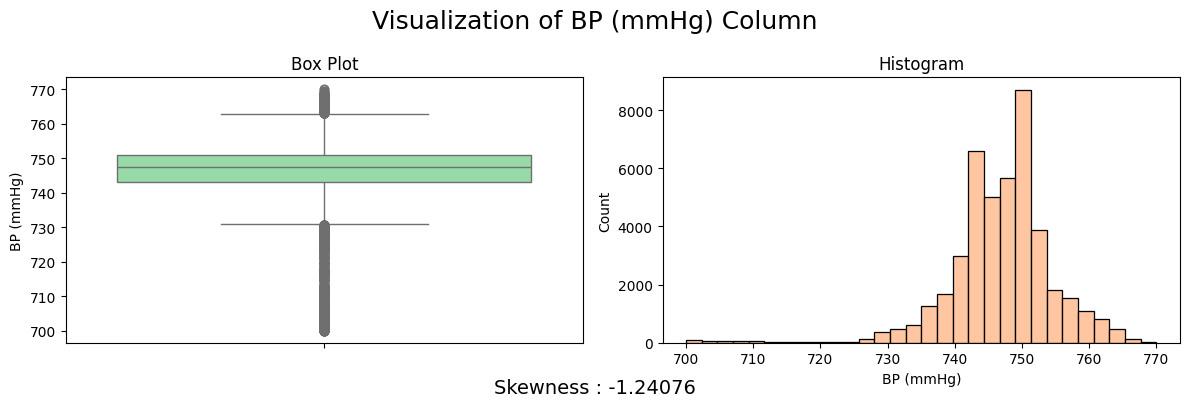

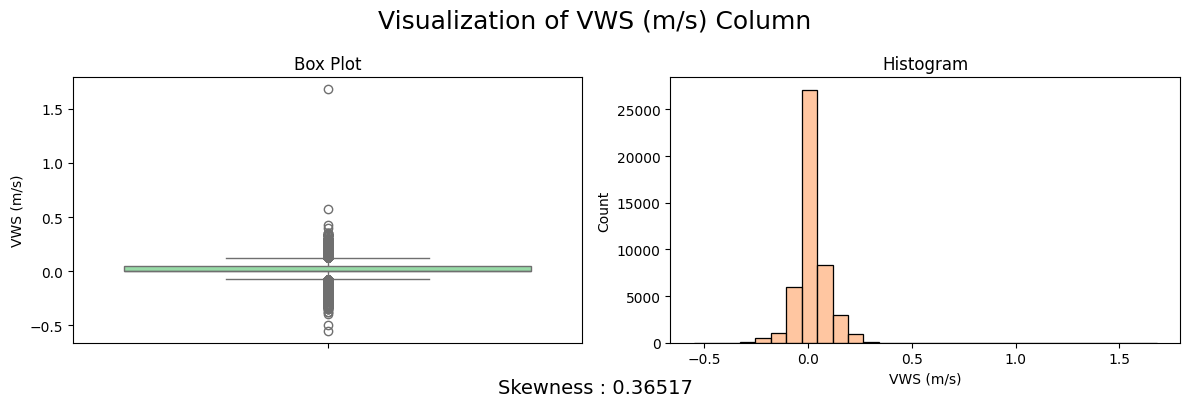

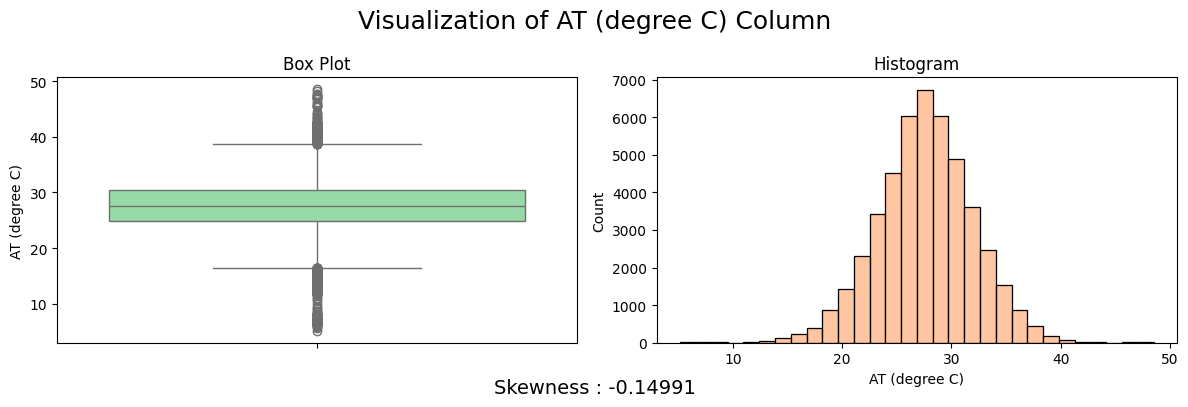

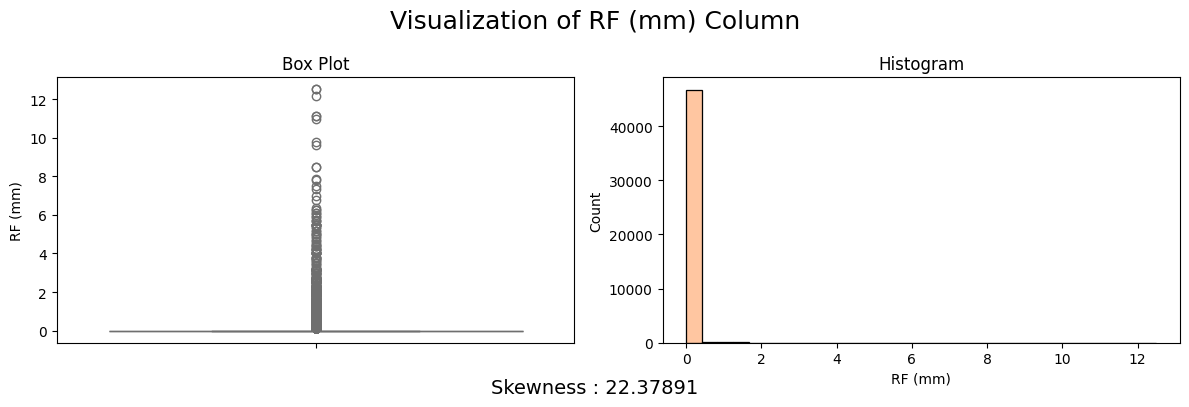

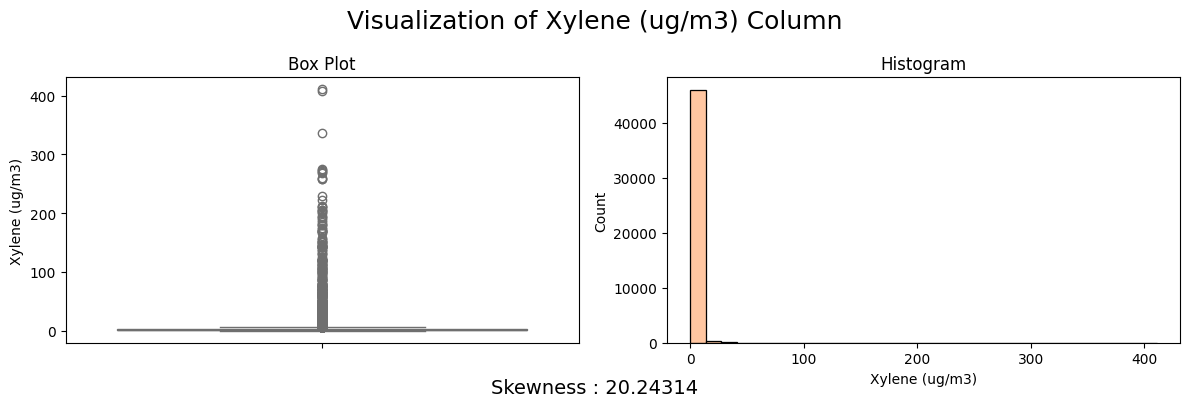

In [65]:
for col in num_col:
  fig, axes = plt.subplots(1,2,figsize=(12,4))
  plt.suptitle(f"Visualization of {col} Column", fontsize = 18)

  sns.boxplot(y = df[col], ax = axes[0], color=sns.color_palette('pastel')[2])
  axes[0].set_title("Box Plot")

  sns.histplot(df[col], ax = axes[1], bins = 30, color=sns.color_palette('pastel')[1])
  axes[1].set_title("Histogram")

  skewness_value = df[col].skew()
  fig.text(0.5, 0.02, f"Skewness : {skewness_value:.5f}", ha='center', fontsize=14)

  plt.tight_layout()
  plt.show()

  print()

The visualization shows :   
1. Most of the columns are **having many outlier values**, so it is needed to input them with a median value if there is several missing values on each column. Because the **LSTM model** will be developed later on, which is sensitive to outlier (that may bring to an overfit model), then **we will treat the outlier with winsorizing method**.
2. The distribution of the numerical data mostlikely is not distributed in form of normal distribution, there are only few of categories that have the skewness value close to 0, but the rest are far away (indicates the high scewness). This facts may bring the model to some biased towards the prediction


## 4. Time-Series Data Visualization

### Air Temperature over Time

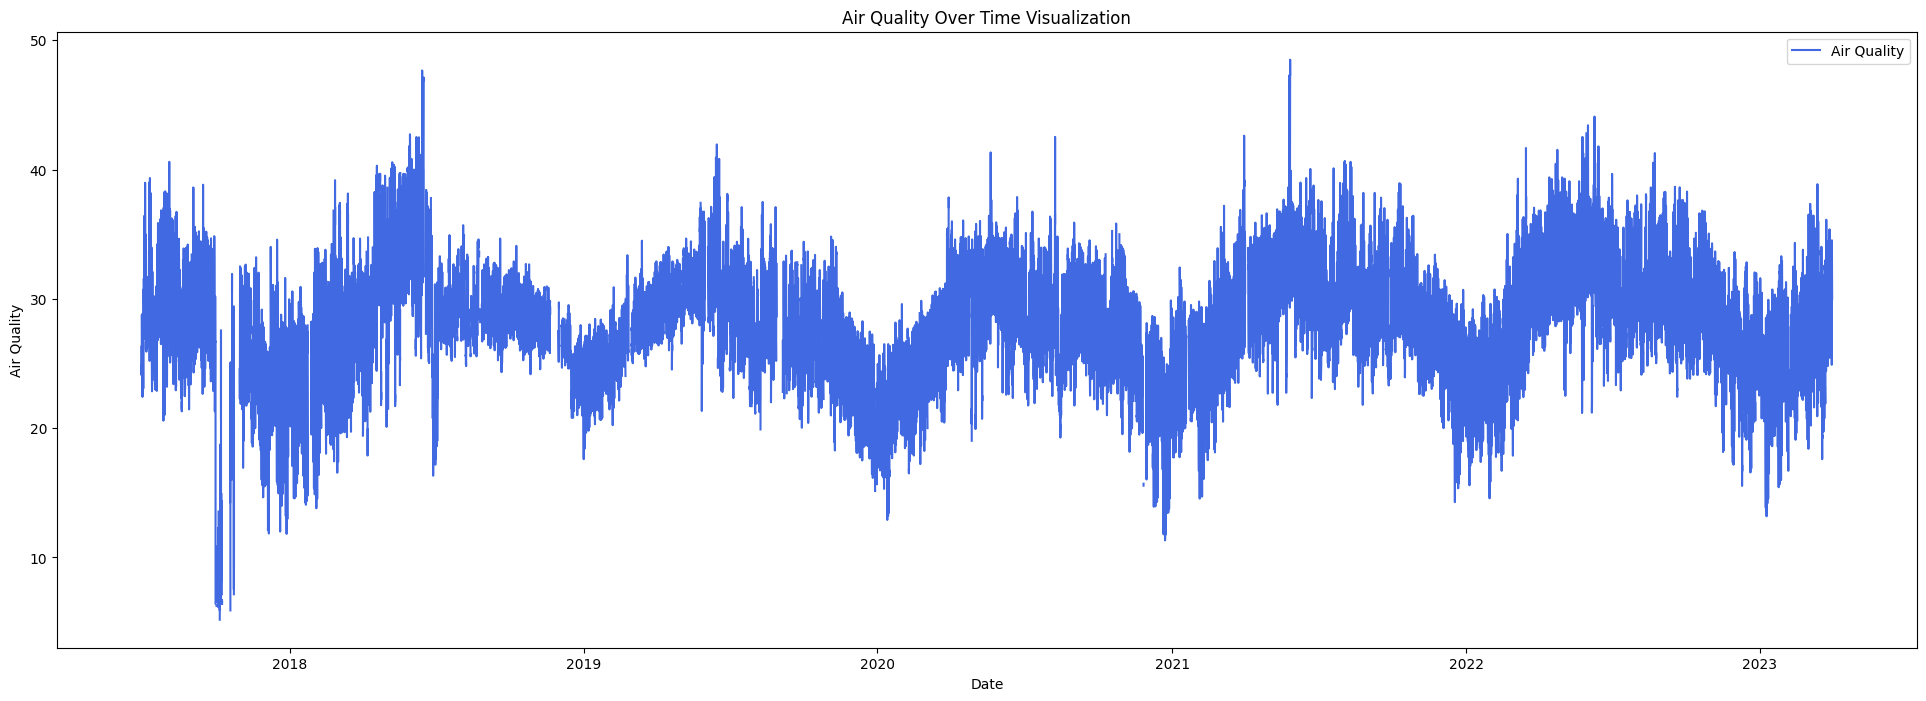

In [66]:
plt.figure(figsize=(24,8))
plt.plot(df['From Date'], df['AT (degree C)'], label="Air Quality", color='royalblue')
plt.title("Air Quality Over Time Visualization")
plt.xlabel("Date")
plt.ylabel("Air Quality")
plt.legend()
plt.show()

That visualization shows :  
1. Seems to have a seasonal pattern because of the consistent wave pattern from years to years that indicates an anual season. This hypothesis will be proofed further on the seasonal decomposement part  
2. Have a high daily fluctuation that based on the fluctuation of the graphs on a day scale. It may indicates the extreme weather as the major problems that many countries are facing right now.
3. Stability on average temperature over the years. Eventhough there is a spike and fluctuation, but overall, the trend from 2017 to 2023 seems stable with no significance change of the yearly pattern. Eventhough, there is still a minor increasement from year to year, indicates the impact of global warning effect through the air temperature.

### Air Temperature in 2022

A Closer look to the Air Quality Over Time in only 2022, as the most actual time rather than the others.

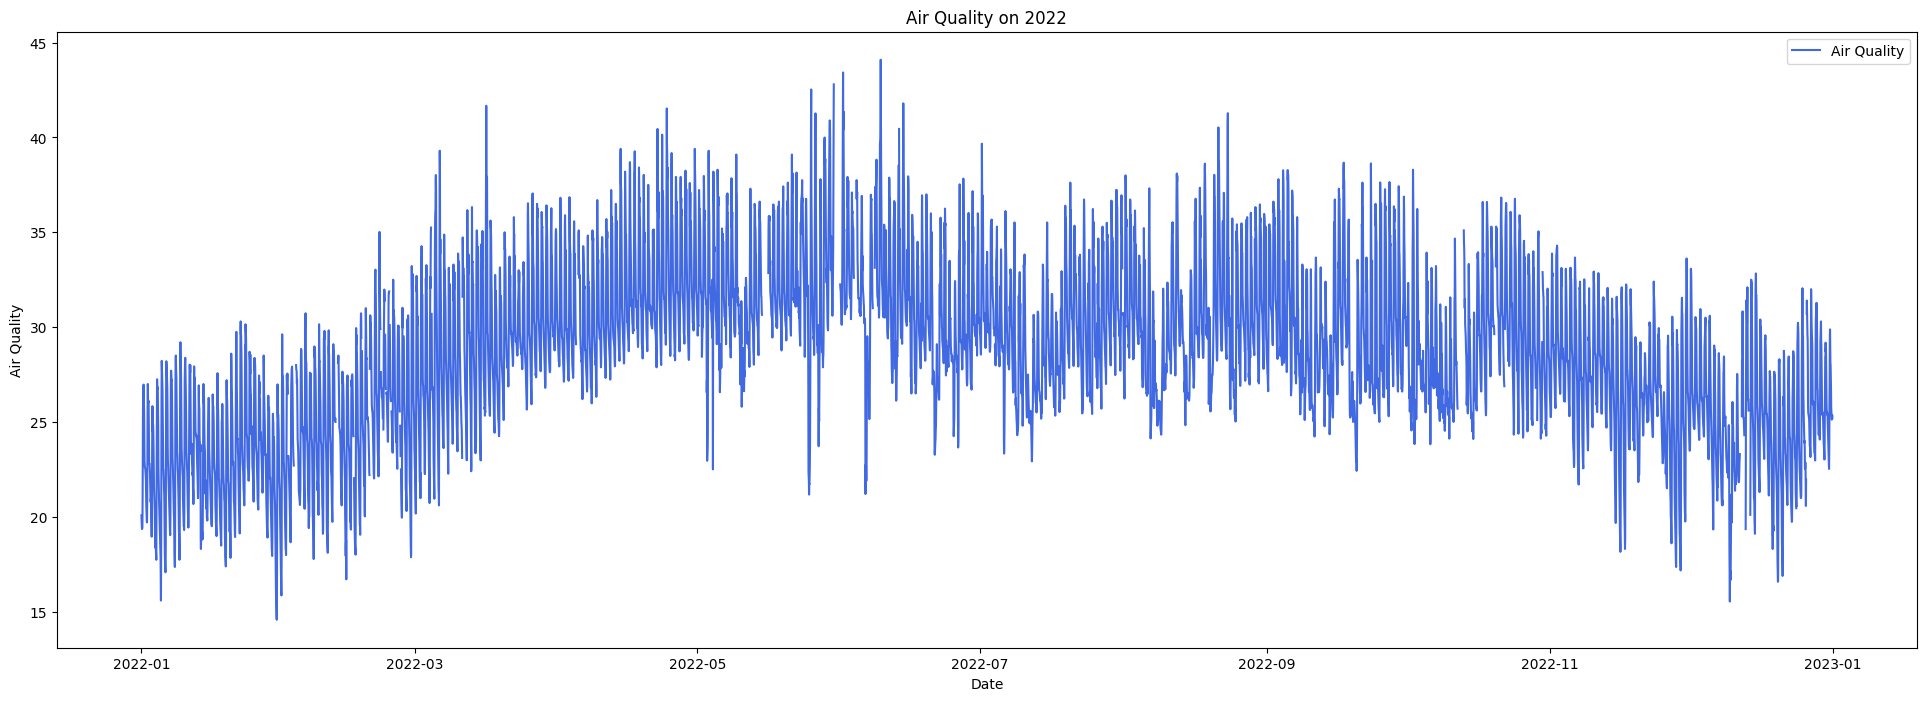

In [67]:
Years_2022 = df[(df['From Date']>"2022-01-01") & (df['From Date']<"2023-01-01")]

plt.figure(figsize=(24,8))
plt.plot(Years_2022['From Date'], Years_2022['AT (degree C)'], label="Air Quality", color='royalblue')
plt.title("Air Quality on 2022")
plt.xlabel("Date")
plt.ylabel("Air Quality")
plt.legend()
plt.show()

The closer graphs visualize that there are high increasement of the temperature on the middle of year, and slowly decrease to the end of year.  

This occasion may caused by the change of season over the year. On the mid of the year, summer and autumn season might be happen. Otherwise, on the end until the beginning of year, it might happening the winter and spring season

### Seasonal Decomposition

Because to findout the Seasonal Decomposition is not able to contains any missing values, so it will be implemented the preprocessing of imputation missing value first before it is processed into the seasonal decomposition

20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:40:06 - cmdstanpy - INFO - Chain [1] done processing


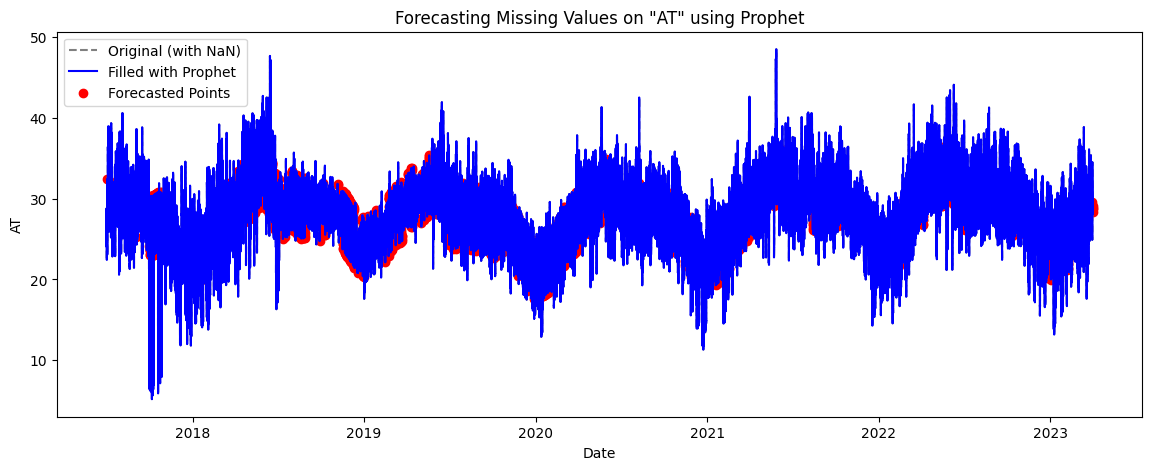

In [69]:
df_prophet = df.rename(columns = {'From Date' : 'ds', 'AT (degree C)':'y'})
df_train = df_prophet.dropna(subset = ['y'])

model = Prophet()
model.fit(df_train)

date = df_prophet[['ds']]
forecast = model.predict(date)

df_prophet['forecast'] = forecast['yhat']
df_prophet['y_filled'] = df_prophet['y']
df_prophet.loc[df_prophet['y'].isna(), 'y_filled'] = df_prophet.loc[df_prophet['y'].isna(), 'forecast']

plt.figure(figsize=(14, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Original (with NaN)', linestyle='--', color='gray')
plt.plot(df_prophet['ds'], df_prophet['y_filled'], label='Filled with Prophet', color='blue')
plt.scatter(df_prophet.loc[df_prophet['y'].isna(), 'ds'], df_prophet.loc[df_prophet['y'].isna(), 'y_filled'],
            color='red', label='Forecasted Points')
plt.title('Forecasting Missing Values on "AT" using Prophet')
plt.xlabel('Date')
plt.ylabel('AT')
plt.legend()
plt.show()

In [ ]:
df['AT (degree C)'] = df_prophet['y_filled']

#### Daily

This scope is for 24 hours period.

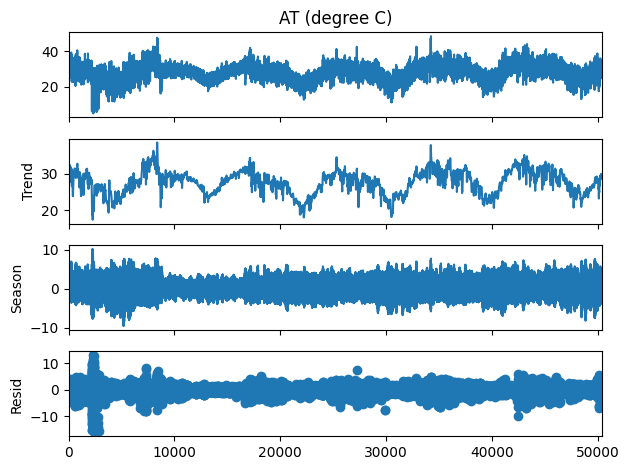

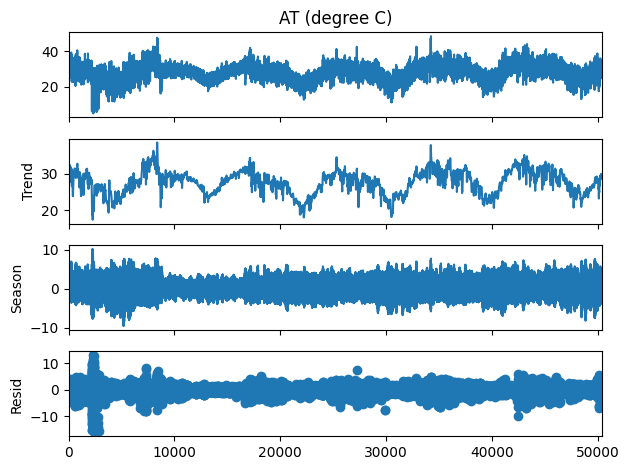

In [ ]:
STL(df['AT (degree C)'], period = 24, seasonal = 7).fit().plot()

#### Weekly

This scope is for 7 days period.

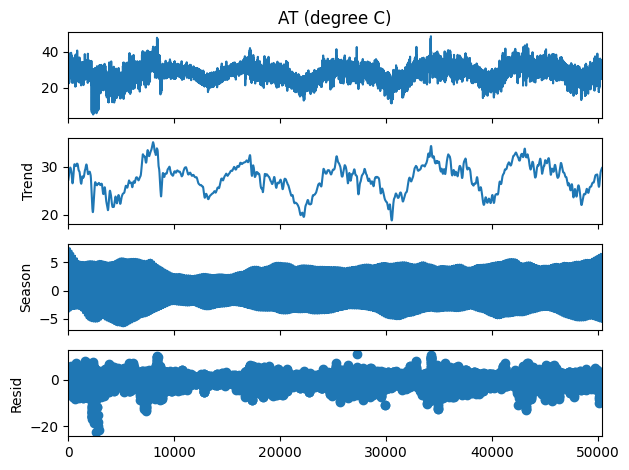

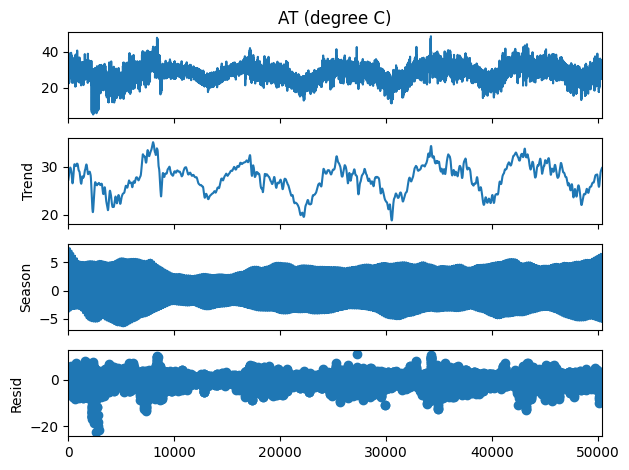

In [ ]:
STL(df['AT (degree C)'], period = 168, seasonal = 21).fit().plot()

#### Monthly

This scope is for 30 days period (approximate for 1 month).

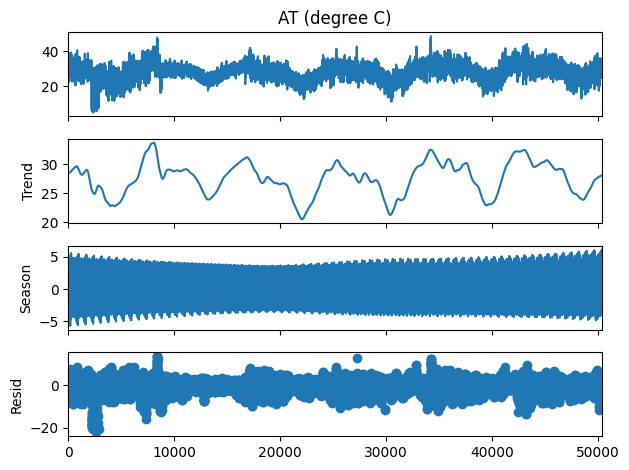

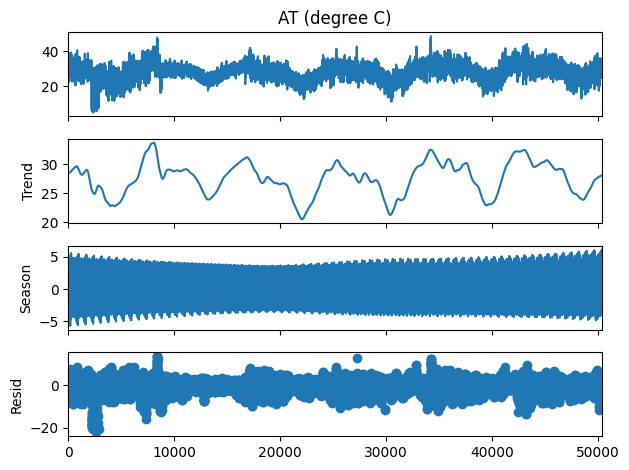

In [ ]:
STL(df['AT (degree C)'], period = 720, seasonal = 51).fit().plot()

#### Yearly

This scope is for 365 days period (approximate for 1 year).

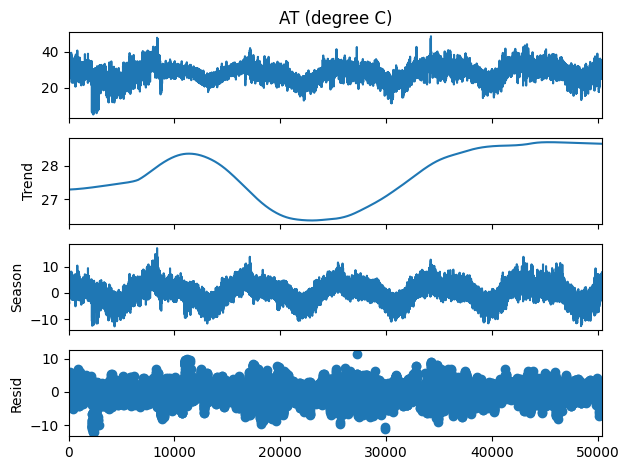

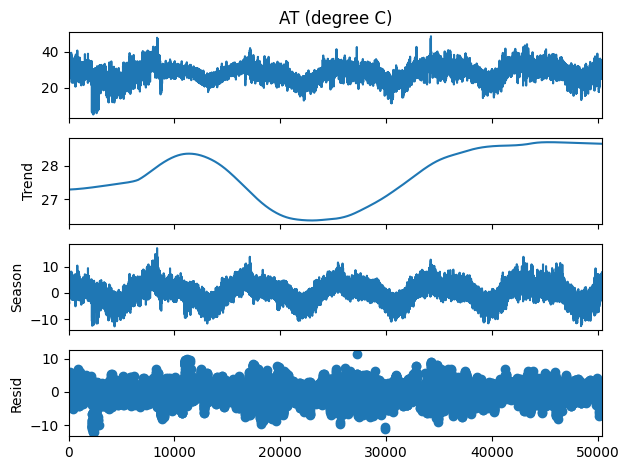

In [ ]:
STL(df['AT (degree C)'], period = 8760, seasonal = 501).fit().plot()

All of the daily, weekly, monthly and yearly seasonal decomposition means : 
* **Trend.** On a year, the trend is like a constant repeated wave pattern, it indicates the stable average of air temperature over the months; that may be caused by the anual weather season. But over the years, the trend is getting decrease on some points, and increasing again; indicates that the average temperature is decreasing during the pandemic year for few times, and is increasing more than before as the global warning and climate change are continously increasing from year to year.
* **Seasonal.** A consistent and regular seasonal pattern is formed like a frequency wave; means that there is a consisten seasonal cycle that repeated from month to month on a year, may be cause by the climate or weather

# 1.b. Data Preprocessing

## Missing Values Inputation

The Interpolation by Time is used as the inputation method, because on the time series data, there is a strong correlation and trend between an observation to the others. Interpolation will fill the NULL values using the trend correlation with the previous one.

In [ ]:
df.set_index('From Date', inplace = True)
df.index

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 01:00:00',
               '2017-07-01 02:00:00', '2017-07-01 03:00:00',
               '2017-07-01 04:00:00', '2017-07-01 05:00:00',
               '2017-07-01 06:00:00', '2017-07-01 07:00:00',
               '2017-07-01 08:00:00', '2017-07-01 09:00:00',
               ...
               '2023-03-31 14:00:00', '2023-03-31 15:00:00',
               '2023-03-31 16:00:00', '2023-03-31 17:00:00',
               '2023-03-31 18:00:00', '2023-03-31 19:00:00',
               '2023-03-31 20:00:00', '2023-03-31 21:00:00',
               '2023-03-31 22:00:00', '2023-03-31 23:00:00'],
              dtype='datetime64[ns]', name='From Date', length=50400, freq=None)

In [ ]:
for col in null_col:
    if col != 'AT (degree C)':
        df[col] = df[col].interpolate(method='time')
        df[col] = df[col].fillna(method='ffill') 
        df[col] = df[col].fillna(method='bfill') 

C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\1610161554.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\1610161554.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')
C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\1610161554.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\1610161554.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')
C:\Users\alexa\AppData\Local\Tem

In [ ]:
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   From Date        50400 non-null  datetime64[ns]
 1   To Date          50400 non-null  datetime64[ns]
 2   PM2.5 (ug/m3)    50400 non-null  float64       
 3   PM10 (ug/m3)     50400 non-null  float64       
 4   NO (ug/m3)       50400 non-null  float64       
 5   NO2 (ug/m3)      50400 non-null  float64       
 6   NOx (ppb)        50400 non-null  float64       
 7   NH3 (ug/m3)      50400 non-null  float64       
 8   SO2 (ug/m3)      50400 non-null  float64       
 9   CO (mg/m3)       50400 non-null  float64       
 10  Ozone (ug/m3)    50400 non-null  float64       
 11  Benzene (ug/m3)  50400 non-null  float64       
 12  Toluene (ug/m3)  50400 non-null  float64       
 13  Temp (degree C)  50400 non-null  float64       
 14  RH (%)           50400 non-null  float

## Outlier Treatment

This dataset has lot of outliers, but there are two kinds of outliers :  
1. The outlier value that is still make sense, just a rare value but still realistic to be happened on several rare condition
2. The outlier value that isn't make sense at all, caused by the error input of measurements  

Then, we will treat the second type, with a winsorizing method, with the cap is the highest value that is possible to be occured, which consist of :  
* PM2.5 -> max : 500
* PM10 -> max : 600
* NO2 -> max : 400
* NH3 -> max : 500
* BP -> max : 770

In [ ]:
realistic_caps = {
    'PM2.5 (ug/m3)': 500,
    'PM10 (ug/m3)': 600,
    'NO2 (ug/m3)': 200,
    'NH3 (ug/m3)': 150,
    'BP (mmHg)': 765
}

for col, cap in realistic_caps.items():
    if col in df.columns:
        df[col] = df[col].apply(lambda x: cap if x > cap else x)


## Train, Validation and Test Split

In [ ]:
val_size = 0.1
test_size = 0.1

df_train = df[:int(len(df) * (1 - val_size - test_size))]
df_val = df[int(len(df) * (1 - val_size - test_size)) : int(len(df) * (1-test_size))]
df_test = df[int(len(df) * (1-test_size)) :]

print(df_train.shape, df_val.shape, df_test.shape)

(40320, 23) (5040, 23) (5040, 23)


## Scaling

There are many outliers on the numerical variable, so it will be scaled by a RobustScaler Method

In [ ]:
target = 'AT (degree C)'
feature_cols = df.columns.drop([target, 'From Date', 'To Date'])

In [ ]:
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

In [ ]:
df_train['AT (degree C)'] = target_scaler.fit_transform(df_train[['AT (degree C)']])
df_val['AT (degree C)'] = target_scaler.transform(df_val[['AT (degree C)']])
df_test['AT (degree C)'] = target_scaler.transform(df_test[['AT (degree C)']])

C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\509495251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AT (degree C)'] = target_scaler.fit_transform(df_train[['AT (degree C)']])
C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\509495251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['AT (degree C)'] = target_scaler.transform(df_val[['AT (degree C)']])
C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\509495251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [ ]:
df_train[feature_cols] = feature_scaler.fit_transform(df_train[feature_cols])
df_val[feature_cols] = feature_scaler.transform(df_val[feature_cols])
df_test[feature_cols] = feature_scaler.transform(df_test[feature_cols])

C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\965752663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[feature_cols] = feature_scaler.fit_transform(df_train[feature_cols])
C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\965752663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[feature_cols] = feature_scaler.transform(df_val[feature_cols])
C:\Users\alexa\AppData\Local\Temp\ipykernel_2036\965752663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [ ]:
df_train = df_train.drop(columns=['From Date', 'To Date'])
df_val = df_val.drop(columns=['From Date', 'To Date'])
df_test = df_test.drop(columns=['From Date', 'To Date'])

## Generating Window Sample

In [ ]:
def generate_windowsample(data, window_size=30, out_col='AT (degree C)'):
    data = data.copy().reset_index(drop=True)
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.loc[i:i + window_size-1].to_numpy())
        y.append(data.loc[i + window_size,out_col])
    return np.array(X), np.array(y)

In [ ]:
window_size = 5

x_train, y_train = generate_windowsample(df_train, window_size=window_size)
x_val, y_val = generate_windowsample(df_val, window_size=window_size)
x_test, y_test = generate_windowsample(df_test, window_size=window_size)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(40315, 5, 21) (40315,)
(5035, 5, 21) (5035,)
(5035, 5, 21) (5035,)


## Converting to Tensor Dataframe

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

# 1.c. Modelling

In [ ]:
inputs = tf.keras.Input(shape=(window_size, 21))
model_layer = LSTM(10)(inputs)
outputs = layers.Dense(1, activation='linear')(model_layer)
base_model = Model(inputs = inputs, outputs = outputs)

In [ ]:
base_model.compile(optimizer='adam', loss='mse')
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,291 (5.04 KB)

 Trainable params: 1,291 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
base_history = base_model.fit(train_ds,validation_data=val_ds,epochs = 30)

Epoch 1/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4089 - val_loss: 0.1343
Epoch 2/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1474 - val_loss: 0.0651
Epoch 3/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0942 - val_loss: 0.0421
Epoch 4/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0838 - val_loss: 0.0377
Epoch 5/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0802 - val_loss: 0.0353
Epoch 6/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0784 - val_loss: 0.0337
Epoch 7/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0762 - val_loss: 0.0322
Epoch 8/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0746 - val_loss: 0.0361
Epoch 9/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0754 - val_loss: 0.0318
Epoch 10/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0749 - val_loss: 0.0333
Epoch 11/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0740 - val_loss: 0.0316
Epoch 12/30
1260/1260 ━━━━━━━━

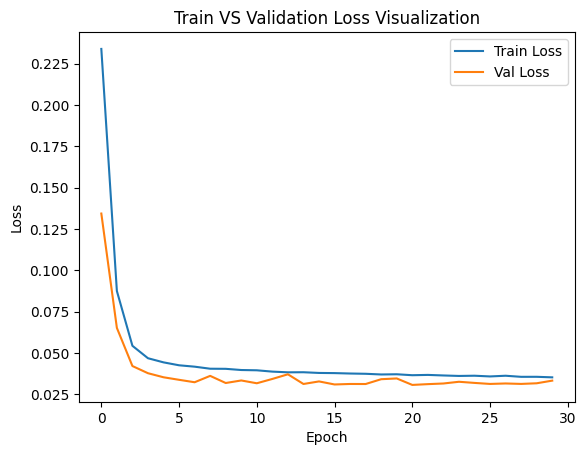

In [ ]:
train_loss = base_history.history['loss']
val_loss = base_history.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 1.d. Modification LSTM Model

## Modification | 1

**Things To Modified:**  

Adding 1 more layer from base architecture, with order :  
* 1st Layer : 10 Neurons
* 2nd Layer : 5 Neurons

In [ ]:
inputs = tf.keras.Input(shape=(window_size, 21))
model_layer = layers.LSTM(10, return_sequences=True)(inputs)
model_layer2 = layers.LSTM(5)(model_layer)
outputs = layers.Dense(1, activation='linear')(model_layer2)
modified_model1 = Model(inputs = inputs, outputs = outputs)
modified_model1.compile(optimizer='adam', loss='mse')
modified_model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 10)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,606 (6.27 KB)

 Trainable params: 1,606 (6.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modified_history1 = modified_model1.fit(train_ds,validation_data=val_ds,epochs = 30)

Epoch 1/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4054 - val_loss: 0.1740
Epoch 2/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1465 - val_loss: 0.0738
Epoch 3/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0950 - val_loss: 0.0504
Epoch 4/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0825 - val_loss: 0.0536
Epoch 5/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0816 - val_loss: 0.0486
Epoch 6/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0804 - val_loss: 0.0475
Epoch 7/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0773 - val_loss: 0.0460
Epoch 8/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0764 - val_loss: 0.0486
Epoch 9/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0750 - val_loss: 0.0417
Epoch 10/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0734 - val_loss: 0.0383
Epoch 11/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0718 - val_loss: 0.0364
Epoch 12/30
1260/1260 ━━━━━━━━

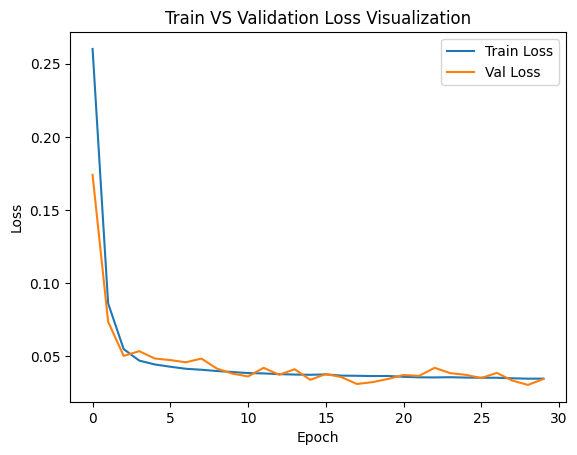

In [ ]:
train_loss = modified_history1.history['loss']
val_loss = modified_history1.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modification | 2 

**Things To Modified:**  

Adding 2 more layer from base architecture, with order :  
* 1st Layer : 10 Neurons
* 2nd Layer : 6 Neurons
* 3rd Layer : 3 Neurons

In [ ]:
inputs = tf.keras.Input(shape=(window_size, 21))
model_layer1 = layers.LSTM(10, return_sequences = True)(inputs)
model_layer2 = layers.LSTM(6, return_sequences = True)(model_layer1)
model_layer3 = layers.LSTM(3)(model_layer2)
outputs = layers.Dense(1, activation='linear')(model_layer3)
modified_model2 = Model(inputs = inputs, outputs = outputs)
modified_model2.compile(optimizer='adam', loss='mse')
modified_model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 10)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 5, 6)           │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,812 (7.08 KB)

 Trainable params: 1,812 (7.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modified_history2 = modified_model2.fit(train_ds,validation_data=val_ds,epochs = 30)

Epoch 1/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4877 - val_loss: 0.3264
Epoch 2/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1981 - val_loss: 0.1101
Epoch 3/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1085 - val_loss: 0.0566
Epoch 4/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0905 - val_loss: 0.0450
Epoch 5/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0815 - val_loss: 0.0514
Epoch 6/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0799 - val_loss: 0.0518
Epoch 7/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0778 - val_loss: 0.0455
Epoch 8/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0761 - val_loss: 0.0421
Epoch 9/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0747 - val_loss: 0.0370
Epoch 10/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0759 - val_loss: 0.0375
Epoch 11/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0732 - val_loss: 0.0377
Epoch 12/30
1260/1260 ━━━━━━━━

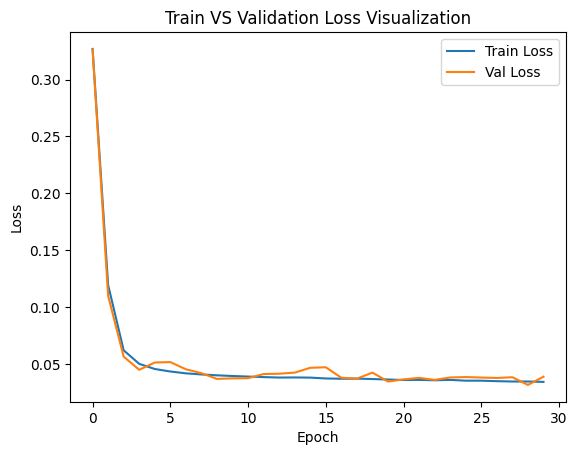

In [ ]:
train_loss = modified_history2.history['loss']
val_loss = modified_history2.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modification | 3

**Things To Modified:**  

Adding 3 more layer from base architecture, with order :  
* 1st Layer : 10 Neurons
* 2nd Layer : 8 Neurons
* 3rd Layer : 6 Neurons
* 4tg Layer : 2 Neurons

In [ ]:
inputs = tf.keras.Input(shape=(window_size, 21))
model_layer1 = layers.LSTM(10, return_sequences = True)(inputs)
model_layer2 = layers.LSTM(8, return_sequences = True)(model_layer1)
model_layer3 = layers.LSTM(6, return_sequences = True)(model_layer2)
model_layer4 = layers.LSTM(2)(model_layer3)
outputs = layers.Dense(1, activation='linear')(model_layer4)
modified_model5 = Model(inputs = inputs, outputs = outputs)
modified_model5.compile(optimizer='adam', loss='mse')
modified_model5.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 5, 10)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 5, 8)           │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 5, 6)           │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 2)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,323 (9.07 KB)

 Trainable params: 2,323 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modified_history5 = modified_model5.fit(train_ds,validation_data=val_ds,epochs = 30)

Epoch 1/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.5058 - val_loss: 0.3930
Epoch 2/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2309 - val_loss: 0.2038
Epoch 3/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1147 - val_loss: 0.0544
Epoch 4/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0864 - val_loss: 0.0549
Epoch 5/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0826 - val_loss: 0.0524
Epoch 6/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0804 - val_loss: 0.0463
Epoch 7/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0771 - val_loss: 0.0546
Epoch 8/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0762 - val_loss: 0.0439
Epoch 9/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0736 - val_loss: 0.0453
Epoch 10/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0745 - val_loss: 0.0615
Epoch 11/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0730 - val_loss: 0.0442
Epoch 12/30
1260/1260 ━━━━━━━━

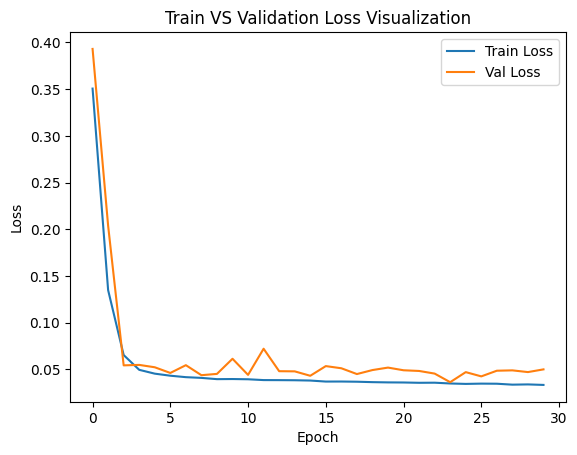

In [ ]:
train_loss = modified_history5.history['loss']
val_loss = modified_history5.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modification #4 : 1 Layer (32 Neurons)

**Things To Modified:**  

Adding the ammount of neurons from base architecture, with order :  
* 1st Layer : 32 Neurons

In [ ]:
inputs = tf.keras.Input(shape=(window_size, 21))
model_layer1 = layers.LSTM(32)(inputs)
outputs = layers.Dense(1, activation='linear')(model_layer1)
modified_model3 = Model(inputs = inputs, outputs = outputs)
modified_model3.compile(optimizer='adam', loss='mse')
modified_model3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,945 (27.13 KB)

 Trainable params: 6,945 (27.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modified_history3 = modified_model3.fit(train_ds,validation_data=val_ds,epochs = 30)

Epoch 1/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2896 - val_loss: 0.0921
Epoch 2/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1037 - val_loss: 0.0598
Epoch 3/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0848 - val_loss: 0.0433
Epoch 4/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0785 - val_loss: 0.0454
Epoch 5/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0761 - val_loss: 0.0551
Epoch 6/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0742 - val_loss: 0.0418
Epoch 7/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0720 - val_loss: 0.0332
Epoch 8/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0729 - val_loss: 0.0380
Epoch 9/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0692 - val_loss: 0.0389
Epoch 10/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0691 - val_loss: 0.0351
Epoch 11/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0669 - val_loss: 0.0351
Epoch 12/30
1260/1260 ━━━━━━━━

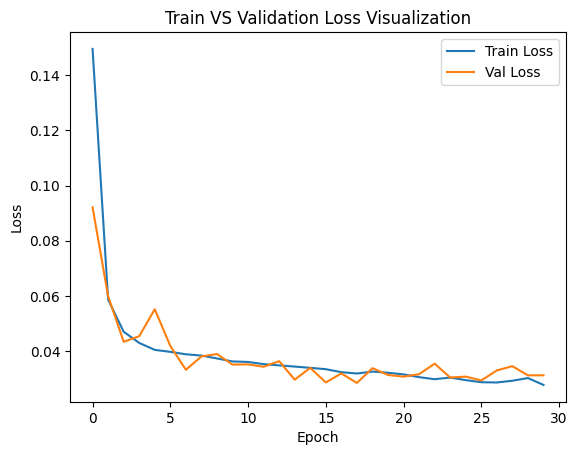

In [ ]:
train_loss = modified_history3.history['loss']
val_loss = modified_history3.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modification | 5

**Things To Modified:**  

Adding the ammount of neurons with dropout from base architecture, with order :  
* 1st Layer : 32 Neurons
* DropOut on 1st Layer

In [ ]:
inputs = tf.keras.Input(shape=(window_size, 21))
model_layer1 = layers.LSTM(32)(inputs)
model_layer1 = layers.Dropout(0.2)(model_layer1)
outputs = layers.Dense(1, activation='linear')(model_layer1)
modified_model4 = Model(inputs = inputs, outputs = outputs)
modified_model4.compile(optimizer='adam', loss='mse')
modified_model4.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,945 (27.13 KB)

 Trainable params: 6,945 (27.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modified_history4 = modified_model4.fit(train_ds,validation_data=val_ds,epochs = 30)

Epoch 1/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2634 - val_loss: 0.1150
Epoch 2/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1178 - val_loss: 0.0603
Epoch 3/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0963 - val_loss: 0.0431
Epoch 4/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0912 - val_loss: 0.0421
Epoch 5/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0866 - val_loss: 0.0355
Epoch 6/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0864 - val_loss: 0.0351
Epoch 7/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0840 - val_loss: 0.0382
Epoch 8/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0838 - val_loss: 0.0338
Epoch 9/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0820 - val_loss: 0.0310
Epoch 10/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0813 - val_loss: 0.0314
Epoch 11/30
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0792 - val_loss: 0.0331
Epoch 12/30
1260/1260 ━━━━━━━━

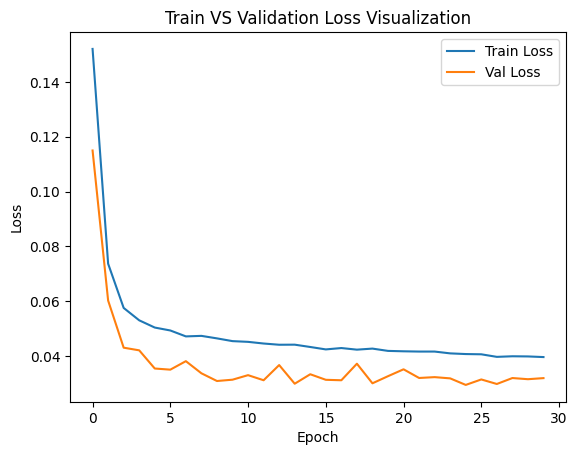

In [ ]:
train_loss = modified_history4.history['loss']
val_loss = modified_history4.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 1.e. Model Evaluation

In [ ]:
def test_regression_model(test_ds,model,scaler = None):
    y = []
    y_preds = []
    for inputs,labels in test_ds:
        y_pred = model.predict(inputs)
        if scaler:
            labels = scaler.inverse_transform(np.array(labels).reshape(-1,1))
            y_pred = scaler.inverse_transform(y_pred)
        try:
            y.extend(labels.numpy())
        except:
            y.extend(labels)
        y_preds.extend(y_pred)
    y, y_preds = np.squeeze(y),np.squeeze(y_preds)
    return {'mae': mean_absolute_error(y, y_preds),
            'mse': mean_squared_error(y, y_preds),
            'r2': r2_score(y, y_preds)}

In [ ]:
model_list = [base_model, modified_model1, modified_model2, modified_model5, modified_model3, modified_model4]
model_names = ['Base Model', '2 Layers (10+5)', '3 Layers (10+6+3)', '4 Layers (10+8+6+2)', '1 Layer (32)', '1 Layer (32) + DropOut']
mae = []
mse = []
r2 = []

for m in model_list:
    results = test_regression_model(test_ds, m, target_scaler)
    mae.append(results['mae'])
    mse.append(results['mse'])
    r2.append(results['r2'])

evaluation_result = pd.DataFrame({
    'Model Name' : model_names,
    'MAE' : mae,
    'MSE' : mse,
    'R Squared' : r2
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [ ]:
evaluation_result

,Model Name,MAE,MSE,R Squared
0,Base Model,0.633803,0.890444,0.945927
1,2 Layers (10+5),0.617270,0.840122,0.948983
2,3 Layers (10+6+3),0.630957,0.807807,0.950945
3,4 Layers (10+8+6+2),0.686969,0.950971,0.942252
4,1 Layer (32),0.607838,0.785777,0.952283
5,1 Layer (32) + DropOut,0.606413,0.785726,0.952286


The best accurate model, which contained of 1 layer with 32 neurons, has : 
* 0.61 unit mean of error between the predicted and actual value
* 0.79 unit squared mean of error between predicted and actual value, it has a significance higher value than MAE indicates that there are containing several outliers
* 95.23% variance on the data are succeed to be explained from the model

# Summary

Based on the training and evaluation process, it can be concluded as : 
* The most converge model is the base model, which consist of 1 LSTM layer with 10 neurons
* The best accurate model is the tuned model, which consists of 1 LSTM layer with 32 neurons    

It indicates that the most converge model, with the most stable loss value on the validation set doesnt mean that it has the best accuracy through the other models. Sometimes, it is needed a more complex model with more neurons, and it may caused the validation loss fluctuative, becaused the data is not have too big size.

# Additional Questions

**Apakah problem ini mungkin menggunakan time series
multivariate, bagaimana mengetahui apakah problem tersebut dapat menjadi multivariate, jelaskan jawaban
anda untuk problem ini!**

Yes, it's very possible to to become the multivariate time series.  

When there is an input variable that has high correlation with target variable, it can be determined the other target variable that the scientist's may predict or having a forecast with it, because all of this dataset has already ordered in a time-series that patterned a season over the weeks, months, and years.  

Example.  
In this case, we only predict about the Air Temperature,  
but we already have a dataset that sorted by a time-series for each observation. So, it is not impossible to predict the other categories too, like the Relative Humidity, Rainfal, etc, as long as it has a high correlation between the categories.

# Explanation Video

https://drive.google.com/file/d/1gUoAYz1M1iu7j3Cg7w4yVkoCn7HWkTrJ/view?usp=sharing